In [1]:
import pandas as pd
import pyreadr

In [2]:
def load_rda(file_paths):

  dataframes = {}

  for file_path in file_paths:
      result = pyreadr.read_r(file_path)

      for key in result.keys():
          dataframes[key] = result[key]

  return dataframes

In [3]:
def missing_values(df):
  return(df.isnull().sum())

In [4]:
def outlier_values(df):
    outliers = pd.Series(dtype="float64")

    for col in df.select_dtypes(include=["number"]):  
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        mask = (df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))
        outliers[col] = mask.mean() * 100  
    return outliers

In [5]:
def clean_data(data_dict):
    cleaned_dict = {}
    for key, df in data_dict.items():
        df_cleaned = df.drop_duplicates()
        if 'RecordBeg' in df_cleaned.columns:
            df_cleaned.loc[:, 'RecordBeg'] = pd.to_datetime(df_cleaned['RecordBeg'], errors='coerce')
        if 'RecordEnd' in df_cleaned.columns:
            df_cleaned.loc[:, 'RecordEnd'] = pd.to_datetime(df_cleaned['RecordEnd'], errors='coerce')

        cleaned_dict[key] = df_cleaned

    return cleaned_dict

In [6]:
file_paths = ['../raw_data/euMTPL.rda']
df = load_rda(file_paths)
df1=clean_data(df)
df_euMTPL=df1['euMTPL']
df_euMTPL

,policy_id,group,fuel_type,year,vehicle_category,vehicle_use,province,horsepower,gender,age,exposure,cost_nc,num_nc,cost_cg,num_cg,cost_fcg,num_fcg,cost_cd,num_cd
0,1,test,B,7.0,1,1,PA,14,M,77,0.487671,0.0,0,0.0,0,0.0,0,0.0,0
1,2,train,B,7.0,1,1,NA,12,M,40,0.019178,0.0,0,0.0,0,0.0,0,0.0,0
2,4,train,B,7.0,1,1,CN,14,M,75,0.032877,0.0,0,0.0,0,0.0,0,0.0,0
3,5,train,B,7.0,1,1,NA,13,M,48,0.043836,0.0,0,0.0,0,0.0,0,0.0,0
4,6,train,B,7.0,1,1,NA,12,F,54,0.046575,0.0,0,0.0,0,0.0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2373192,2595210,test,B,9.0,1,1,RM,14,F,40,0.246575,0.0,0,0.0,0,0.0,0,0.0,0
2373193,2595211,train,B,9.0,1,1,LE,14,M,52,0.756164,0.0,0,0.0,0,0.0,0,0.0,0
2373194,2595212,test,E,9.0,1,1,LE,1,F,46,0.008219,0.0,0,0.0,0,0.0,0,0.0,0
2373195,2595213,test,T,9.0,1,1,LE,15,M,25,0.723288,0.0,0,0.0,0,0.0,0,0.0,0


In [7]:
df_euMTPL["ClaimNb"] = df_euMTPL[["num_nc", "num_cg", "num_cd", "num_fcg"]].fillna(0).sum(axis=1)
df_euMTPL["ClaimAmount"] = df_euMTPL[['cost_nc', 'cost_cg', 'cost_fcg', 'cost_cd']].fillna(0).sum(axis=1)

#Suppression des anciennes colonnes
cols_to_drop = ["num_nc", "num_cg", "num_cd", "num_fcg", 'cost_nc', 'cost_cg', 'cost_fcg', 'cost_cd']
df_euMTPL.drop(columns=cols_to_drop, inplace=True)

# Vérification
df_euMTPL.head()

,policy_id,group,fuel_type,year,vehicle_category,vehicle_use,province,horsepower,gender,age,exposure,ClaimNb,ClaimAmount
0,1,test,B,7.0,1,1,PA,14,M,77,0.487671,0,0.0
1,2,train,B,7.0,1,1,NA,12,M,40,0.019178,0,0.0
2,4,train,B,7.0,1,1,CN,14,M,75,0.032877,0,0.0
3,5,train,B,7.0,1,1,NA,13,M,48,0.043836,0,0.0
4,6,train,B,7.0,1,1,NA,12,F,54,0.046575,0,0.0


In [9]:

url = "https://fr.wikipedia.org/wiki/Province_d%27Italie"
tables = pd.read_html(url)

# On part du bon tableau (en général tables[3])
df = tables[3]

# On garde uniquement Sigle et Densité
df_provinces_italie = df[['Sigle', 'Densité (hab./km2)']].copy()

# Nettoyage de la densité
df_provinces_italie['Densité (hab./km2)'] = (
    df_provinces_italie['Densité (hab./km2)']
    .astype(str)
    .str.replace('+', '', regex=False)
    .str.replace('\xa0', '', regex=False)
    .str.replace(',', '', regex=False)
    .str.strip()
)

# Conversion en float (avec coercition des erreurs)
df_provinces_italie['Densité (hab./km2)'] = pd.to_numeric(
    df_provinces_italie['Densité (hab./km2)'], errors='coerce'
)

# Remplir les densités manquantes à la main
densites_manquantes = {
    'CA': 123.0,   # Cagliari
    'CI': 87.0,    # Carbonia-Iglesias
    'NU': 36.0,
    'OG': 188.0,
    'OR': 378.0,
    'SS': 221.0,
    'VS': 68.0
}

# Ajouter la province de Novare (NA) qui ne s'est pas enregistré lors du scraping
if 'NA' not in df_provinces_italie['Sigle'].values:
    df_provinces_italie = pd.concat([
        df_provinces_italie,
        pd.DataFrame([{'Sigle': 'NA', 'Densité (hab./km2)': 429}])
    ], ignore_index=True)


for code, densite in densites_manquantes.items():
    df_provinces_italie.loc[df_provinces_italie['Sigle'] == code, 'Densité (hab./km2)'] = densite

# Trier par ordre alphabétique du sigle
df_provinces_italie = df_provinces_italie.sort_values(by='Sigle').reset_index(drop=True)

df_provinces_italie.to_csv('provinces_italie.csv', index=False)

In [10]:
df_euMTPL = df_euMTPL.merge(
    df_provinces_italie.rename(columns={'Sigle': 'province', 'Densité (hab./km2)': 'Density'}),
    on='province',
    how='left'
)
df_euMTPL

,policy_id,group,fuel_type,year,vehicle_category,vehicle_use,province,horsepower,gender,age,exposure,ClaimNb,ClaimAmount,Density
0,1,test,B,7.0,1,1,PA,14,M,77,0.487671,0,0.0,250.0
1,2,train,B,7.0,1,1,NA,12,M,40,0.019178,0,0.0,429.0
2,4,train,B,7.0,1,1,CN,14,M,75,0.032877,0,0.0,86.0
3,5,train,B,7.0,1,1,NA,13,M,48,0.043836,0,0.0,429.0
4,6,train,B,7.0,1,1,NA,12,F,54,0.046575,0,0.0,429.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2373192,2595210,test,B,9.0,1,1,RM,14,F,40,0.246575,0,0.0,784.0
2373193,2595211,train,B,9.0,1,1,LE,14,M,52,0.756164,0,0.0,296.0
2373194,2595212,test,E,9.0,1,1,LE,1,F,46,0.008219,0,0.0,296.0
2373195,2595213,test,T,9.0,1,1,LE,15,M,25,0.723288,0,0.0,296.0


In [11]:
df_euMTPL = df_euMTPL.rename(columns={
    'policy_id': 'Id_policy',
    'ClaimAmount': 'ClaimAmount',
    'ClaimNb': 'ClaimNb',
    'exposure': 'Exposure',
    'horsepower': 'Power',
    'age': 'DriverAge',
    'fuel_type': 'Fuel_type',
    'gender':'Sex'
})

df_euMTPL['Sinistre'] = (df_euMTPL['ClaimAmount'] > 0).astype(int)
df_euMTPL['Sex'] = df_euMTPL['Sex'].apply(lambda x: 1 if x == 'M' else 0)

features = ["Exposure", 'Power', 'DriverAge', "Fuel_type", "Density", "Sex", 'Sinistre']

df_euMTPL=df_euMTPL[features]
df_euMTPL


,Exposure,Power,DriverAge,Fuel_type,Density,Sex,Sinistre
0,0.487671,14,77,B,250.0,1,0
1,0.019178,12,40,B,429.0,1,0
2,0.032877,14,75,B,86.0,1,0
3,0.043836,13,48,B,429.0,1,0
4,0.046575,12,54,B,429.0,0,0
...,...,...,...,...,...,...,...
2373192,0.246575,14,40,B,784.0,0,0
2373193,0.756164,14,52,B,296.0,1,0
2373194,0.008219,1,46,E,296.0,0,0
2373195,0.723288,15,25,T,296.0,1,0


In [12]:
carburant_dict = {
    'B': 'Regular',   # Bioéthanol ou autres carburants bio
    'E': 'Regular',   # Ethanol
    'S': 'Regular',   # Super essence
    'T': 'Regular',   # Autre carburant de type essence
    'D': 'Diesel',    # Diesel
    'G': 'Diesel',    # Gaz naturel comprimé (GNC)
    'M': 'Diesel',    # Méthane (utilisé dans les véhicules au gaz)
    'P': 'Diesel'     # Propane (utilisé pour des véhicules à gaz)
}

df_euMTPL['Fuel_type'] = df_euMTPL['Fuel_type'].map(carburant_dict)
df_euMTPL['Fuel_type'] = df_euMTPL['Fuel_type'].apply(lambda x: 1 if x == 'Diesel' else 0)
df_euMTPL


,Exposure,Power,DriverAge,Fuel_type,Density,Sex,Sinistre
0,0.487671,14,77,0,250.0,1,0
1,0.019178,12,40,0,429.0,1,0
2,0.032877,14,75,0,86.0,1,0
3,0.043836,13,48,0,429.0,1,0
4,0.046575,12,54,0,429.0,0,0
...,...,...,...,...,...,...,...
2373192,0.246575,14,40,0,784.0,0,0
2373193,0.756164,14,52,0,296.0,1,0
2373194,0.008219,1,46,0,296.0,0,0
2373195,0.723288,15,25,0,296.0,1,0


In [13]:
# Proportion des classes dans df_beMTPL
print(df_euMTPL['Sinistre'].value_counts(normalize=True))


Sinistre
0    0.922623
1    0.077377
Name: proportion, dtype: float64


In [15]:
# Nombre de NaN par colonne
df_euMTPL.isna().sum()

# Nombre de NaN avec uniquement les colonnes concernées
df_euMTPL.isna().sum()[df_euMTPL.isna().sum() > 0]

# Nombre de NaN + pourcentage pour chaque colonne concernée
total = len(df_euMTPL)
nan_info = df_euMTPL.isna().sum()[df_euMTPL.isna().sum() > 0].sort_values(ascending=False)
nan_percentage = (nan_info / total * 100).round(2)
pd.DataFrame({'Nombre de NaN': nan_info, 'Pourcentage (%)': nan_percentage})


,Nombre de NaN,Pourcentage (%)
Density,820,0.03


In [16]:
df_euMTPL = df_euMTPL.dropna()


In [21]:
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split

# Colonnes catégorielles : Fuel_type (col 3), Sex (col 5)
cat_features = [3, 5]

# Séparer les features et la target
X = df_euMTPL.drop(columns='Sinistre')
y = df_euMTPL['Sinistre']

# Appliquer SMOTENC avec sampling_strategy pour atteindre 30 % de sinistres
smote_nc = SMOTENC(categorical_features=cat_features, sampling_strategy=0.43, random_state=42)
X_res, y_res = smote_nc.fit_resample(X, y)

# Reformer la base
df_euMTPL = X_res.copy()
df_euMTPL['Sinistre'] = y_res

# Vérification
proportions = df_euMTPL['Sinistre'].value_counts(normalize=True)
print(proportions)


Sinistre
0    0.699301
1    0.300699
Name: proportion, dtype: float64


/tmp/ipykernel_8120/3663865984.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_euMTPL, x='Sinistre', palette='Set2')


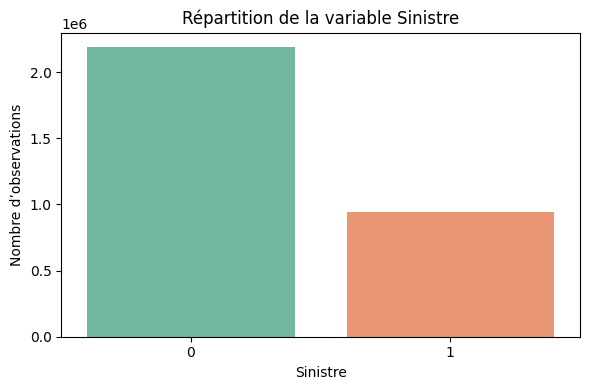

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(data=df_euMTPL, x='Sinistre', palette='Set2')
plt.title('Répartition de la variable Sinistre')
plt.xlabel('Sinistre')
plt.ylabel('Nombre d’observations')
plt.tight_layout()
plt.show()


In [23]:
df_euMTPL.to_csv('../data/european_data.csv', index=False)